<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (617/617), done.
Updating files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:16<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:03<00:00, 173MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:03<00:00, 167MB/s]


In [2]:
import torchvision
from torchvision.io import read_image
from torchvision import transforms
import torch
import torch.nn as nn
from torch.functional import F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install facenet-pytorch --quiet
!pip install timm --quiet
import timm
from facenet_pytorch import MTCNN
from PIL import Image
import shutil
# ignore np.VisibleDeprecationWarning for image_index because it contains list of lists of different lengths
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.0 MB/s eta 0:00:00


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)
    

In [5]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform, has_data={'image': True, 'text': False})
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform, has_data={'image': True, 'text': False})

In [6]:
batch_size = 32
train_loader_MSCTD = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader_MSCTD = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader_MSCTD = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

# PART 1 : Face Analysis

## Subpart 1

### Step 1

In [7]:
def crop_faces_batch(image, boxes):
    """
    :param image: image tensor of shape (batch_size, height, width, channels)
    :param boxes: bounding boxes for the faces of shape (batch_size, num_faces, 4) where 4 is (x1, y1, x2, y2). Note that some images may not have any faces
    :return: 
    :param cropped_images: list of cropped faces with length equal to the batch size. each element is a list of cropped faces for that image and none if no faces are detected
    """
    cropped_images = [[image[i, max(int(y1),0):max(int(y2),0), max(int(x1),0):max(int(x2),0)] for x1, y1, x2, y2 in boxes[i]] if boxes[i] is not None else None for i in range(image.shape[0])]
    return cropped_images


In [ ]:
# define a function that given the data loader, uses the crop_faces_batch to save the cropped images and their sentiments
def save_cropped_images(data_loader, face_detector, faces_path, sentiments_path):
    """
    :param data_loader: data loader for the dataset
    :param face_detector: face detector
    :param faces_path: path to save the cropped faces
    :param sentiments_path: path to save the sentiments
    :return: 
    """
    sentiments = []
    image_index = 0
    shutil.rmtree(faces_path, ignore_errors=True)
    os.makedirs(faces_path, exist_ok=True)
    for i, (image, sentiment) in enumerate(data_loader):
        print("Processing batch {}/{}".format(i+1, len(data_loader))) if i % 50 == 0 else None
        boxes, _ = face_detector.detect(image)
        cropped_images_batch = crop_faces_batch(image, boxes)
        # cropped_images_batch contains a list, where each element is a list with length equal to the number of faces in that image and none if no faces are detected
        # we want to save the cropped images with their corresponding sentiments
        for cropped_images, s in zip(cropped_images_batch, sentiment):
            if cropped_images is not None:
                sentiments.extend([s] * len(cropped_images))
                for image, index in zip(cropped_images, range(image_index, image_index + len(cropped_images))):
                    image_path = os.path.join(faces_path, str(index)+'.jpg')
                    Image.fromarray(image.numpy()).save(image_path)
                image_index += len(cropped_images)

    with open(sentiments_path, 'w') as f:
        f.write('\n'.join([str(sentiment.item()) for sentiment in sentiments]))
        
    
face_detector = MTCNN(keep_all=True, device=device, thresholds=[0.8, 0.9, 0.9])
# save the cropped faces and sentiments for the train, dev, and test sets
save_cropped_images(train_loader_MSCTD, face_detector, 'data/train/image', 'data/train/train_sentiments.txt')
save_cropped_images(dev_loader_MSCTD, face_detector, 'data/dev/image', 'data/dev/dev_sentiments.txt')
save_cropped_images(test_loader_MSCTD, face_detector, 'data/test/image', 'data/test/test_sentiments.txt')


Processing batch 1/633
Processing batch 51/633
Processing batch 101/633
Processing batch 151/633
Processing batch 201/633
Processing batch 251/633
Processing batch 301/633
Processing batch 351/633
Processing batch 401/633
Processing batch 451/633
Processing batch 501/633
Processing batch 551/633
Processing batch 601/633
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159
Processing batch 1/159
Processing batch 51/159
Processing batch 101/159
Processing batch 151/159


In [ ]:
# zip the folders data/train, data/dev, and data/test
shutil.make_archive('data/train', 'zip', 'data/train')
shutil.make_archive('data/dev', 'zip', 'data/dev')
shutil.make_archive('data/test', 'zip', 'data/test')

'/content/data/test.zip'

In [8]:
# Download zip files from drive
# TODO
!mkdir data data/train data/dev data/test
%cd /content/data/train
!gdown 1ky9j5FVBKbLJHYfSiS61ldEv1q-OwpOF # train
!unzip -q train.zip
%cd /content/data/dev
!gdown 1-0WrOQIaU6D9k_trKSz3RZusdDNjuwdj # Dev
!unzip -q dev.zip
%cd /content/data/test
!gdown 1-2tXeQbGOeCklQaKW7eGg4ebXH7o1Aeb # Test
!unzip -q test.zip
%cd /content

/content/data/train
Downloading...
From: https://drive.google.com/uc?id=1ky9j5FVBKbLJHYfSiS61ldEv1q-OwpOF
To: /content/data/train/train.zip
100% 81.9M/81.9M [00:00<00:00, 160MB/s]
/content/data/dev
Downloading...
From: https://drive.google.com/uc?id=1-0WrOQIaU6D9k_trKSz3RZusdDNjuwdj
To: /content/data/dev/dev.zip
100% 23.3M/23.3M [00:00<00:00, 150MB/s]
/content/data/test
Downloading...
From: https://drive.google.com/uc?id=1-2tXeQbGOeCklQaKW7eGg4ebXH7o1Aeb
To: /content/data/test/test.zip
100% 23.8M/23.8M [00:00<00:00, 217MB/s]
/content


### Step 2

In [9]:
# create a custom dataset class that takes as input the cropped faces path and the sentiments path 
# the sentiments are the targets for the model
class CroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        self.faces_path = faces_path
        self.transform = transform
        self.sentiments = np.loadtxt(sentiments_path)
        self.sentiments = torch.from_numpy(self.sentiments)
        self.sentiments = self.sentiments.type(torch.LongTensor)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.faces_path, str(index)+'.jpg')
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        sentiment = self.sentiments[index]
        return image, sentiment
    
    def __len__(self):
        return len(self.sentiments)

In [10]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
face_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_face = CroppedFaces('data/train/image', 'data/train/train_sentiments.txt', transform=face_transform)
dev_dataset_face = CroppedFaces('data/dev/image', 'data/dev/dev_sentiments.txt', transform=face_transform)
test_dataset_face = CroppedFaces('data/test/image', 'data/test/test_sentiments.txt', transform=face_transform)

train_loader_face = DataLoader(train_dataset_face, batch_size=32, shuffle=True)
dev_loader_face = DataLoader(dev_dataset_face, batch_size=32, shuffle=False)
test_loader_face = DataLoader(test_dataset_face, batch_size=32, shuffle=False)

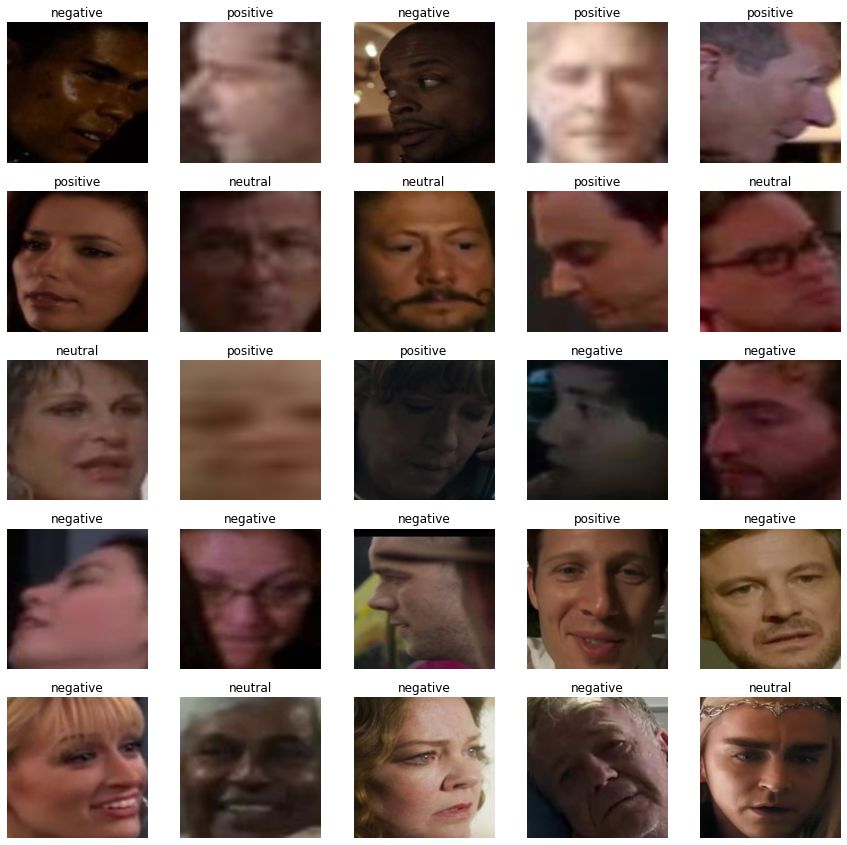

In [18]:
# show some images from the train set
def plot_random_images(dataset, num_cols, num_rows):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))
    for i in range(num_rows):
        for j in range(num_cols):
            index = np.random.randint(len(dataset))
            image, sentiment = dataset[index]
            image = image.numpy()
            image = np.transpose(image, (1, 2, 0))
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)
            axes[i, j].imshow(image)
            # set title to positive if sentiment is 2, negative if 1, and neutral if 0
            axes[i, j].set_title('positive' if sentiment == 2 else 'negative' if sentiment == 1 else 'neutral')
            axes[i, j].axis('off')
    plt.show()

plot_random_images(train_dataset_face, 5, 5)

In [19]:
# Instantiate the model, move it to device, and define the optimizer and loss function
model = timm.create_model('resnet18', pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)
# comment the below 2 lines if you want to retrain the model
!gdown 1-5YLfvvfteVdWzS6PRoVpcaMYgv3dTwd 
model.load_state_dict(torch.load('face_sentiment_classifier.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = nn.CrossEntropyLoss()

Downloading...
From: https://drive.google.com/uc?id=1-5YLfvvfteVdWzS6PRoVpcaMYgv3dTwd
To: /content/face_sentiment_classifier.pt
100% 44.8M/44.8M [00:00<00:00, 247MB/s]


In [ ]:
# define a function to train the model
def train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10):
    """
    :param model: model to train
    :param train_loader: train data loader
    :param dev_loader: dev data loader
    :param optimizer: optimizer to use
    :param loss_function: loss function to use
    :param num_epochs: number of epochs to train for
    :return: train_losses, train_accs, dev_losses, dev_accs
    """
    train_losses = []
    train_accs = []
    dev_losses = []
    dev_accs = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        model.train()
        train_loss = 0
        train_correct = 0
        for i, (image, sentiment) in enumerate(train_loader):
            image = image.to(device)
            sentiment = sentiment.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, sentiment)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_dataset_face)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print("Train loss: {}, train accuracy: {}".format(train_loss, train_acc))
        model.eval()
        dev_loss = 0
        dev_correct = 0
        with torch.no_grad():
            for i, (image, sentiment) in enumerate(dev_loader):
                image = image.to(device)
                sentiment = sentiment.to(device)
                output = model(image)
                loss = loss_function(output, sentiment)
                dev_loss += loss.item()
                dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
        dev_loss /= len(dev_loader)
        dev_acc = dev_correct / len(dev_dataset_face)
        dev_losses.append(dev_loss)
        dev_accs.append(dev_acc)
        print("Dev loss: {}, dev accuracy: {}".format(dev_loss, dev_acc))
    return train_losses, train_accs, dev_losses, dev_accs


In [ ]:
# train the model
train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader_face, dev_loader_face, optimizer, loss_function, num_epochs=10)

Epoch 1/10
Train loss: 1.0890547935005344, train accuracy: 0.3811790113581827
Dev loss: 1.0964226292065924, dev accuracy: 0.3715175352343494
Epoch 2/10
Train loss: 1.0849257704546995, train accuracy: 0.3913373860182371
Dev loss: 1.0985554069748724, dev accuracy: 0.3698787282858079
Epoch 3/10
Train loss: 1.0835219271804974, train accuracy: 0.39217725163973766
Dev loss: 1.091092832425502, dev accuracy: 0.393477548344805
Epoch 4/10
Train loss: 1.0809258041174516, train accuracy: 0.3938969764837626
Dev loss: 1.097547489935191, dev accuracy: 0.37135365453949526
Epoch 5/10
Train loss: 1.0805906762399942, train accuracy: 0.3944568868980963
Dev loss: 1.092459939537248, dev accuracy: 0.385611274991806
Epoch 6/10
Train loss: 1.079574223217147, train accuracy: 0.39881618940969443
Dev loss: 1.0988818279111572, dev accuracy: 0.3729924614880367
Epoch 7/10
Train loss: 1.078635914094003, train accuracy: 0.3977763557830747
Dev loss: 1.1012953551027787, dev accuracy: 0.3556211078334972
Epoch 8/10
Train 

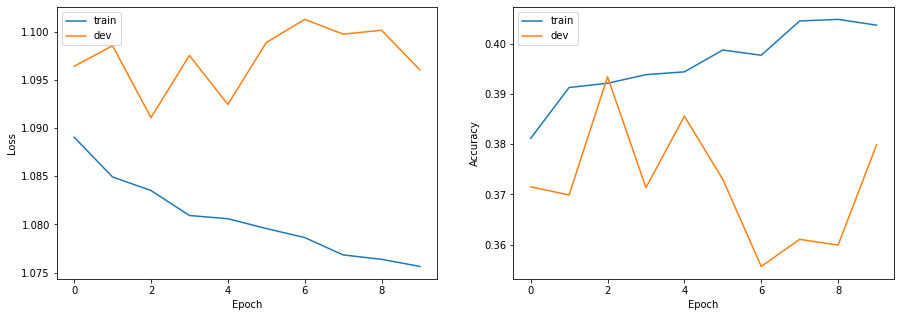

In [ ]:
# define a function that given the train_losses, train_accs, dev_losses, and dev_accs, plots the train and dev losses and accuracies
def plot_train_dev(train_losses, train_accs, dev_losses, dev_accs):
    # TODO: implement this function
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(train_losses, label='train')
    axes[0].plot(dev_losses, label='dev')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(train_accs, label='train')
    axes[1].plot(dev_accs, label='dev')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()
    

# plot the train and dev losses and accuracies
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

In [20]:
# evaluate the model on the test set
model.eval()
test_correct = 0
with torch.no_grad():
    for i, (image, sentiment) in enumerate(test_loader_face):
        image = image.to(device)
        sentiment = sentiment.to(device)
        output = model(image)
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_dataset_face)
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.31857416879795397


In [ ]:
# save the model
torch.save(model.state_dict(), 'face_sentiment_classifier.pt')

### Step 3

In [21]:
# define a class model that in its _call_ function takes an image and returns 3 values,
# which correspond to the number of positive, negative, and neutral faces in the image
# the model does not need to be trained and can be a simple function
# it takes face_detector and face_sentiment_classifier and image_transform as arguments
# it should be able to take a batch of images as input and return a batch of predictions
class FaceSentimentCounter:
    def __init__(self, face_detector, face_sentiment_classifier, image_transform):
        self.face_detector = face_detector
        self.face_sentiment_classifier = face_sentiment_classifier
        self.image_transform = image_transform
    def __call__(self, images):
        # image.shape = (batch_size, height, width, channels)
        boxes, _ = self.face_detector.detect(images)
        # boxes.shape = (batch_size, num_faces, 4) (elements of boxes can be None)
        cropped_faces = crop_faces_batch(images, boxes)
        # cropped_faces.shape = (batch_size, num_faces, height, width, channels) (elements of cropped_faces can be None)
        predictions = []
        for faces in cropped_faces:
            # faces.shape = (num_faces, height, width, channels) (elements of faces can be None)
            if faces is None:
                predictions.append([0, 0, 0])
            else:
                faces = torch.stack([self.image_transform(face.float()) for face in faces])
                # faces.shape = (num_faces, channels, height, width)
                faces = faces.to(device)
                output = self.face_sentiment_classifier(faces)
                # output.shape = (num_faces, 3)
                output = torch.argmax(output, dim=1)
                # output.shape = (num_faces,)
                output = output.cpu().numpy()
                predictions.append(np.bincount(output, minlength=3))
        return torch.tensor(np.array(predictions))

# instantiate the model
face_detector = MTCNN(keep_all=True, device=device)
# the input image is of size (height, width, channels) and uint8
# the output image should be of size (channels, height, width) and float32 and normalized to [-1, 1]
face_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.permute(2, 0, 1)),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
face_sentiment_counter = FaceSentimentCounter(face_detector, model, face_transform)

In [74]:
train_predictions = []
train_sentiments = []
for i, (image, sentiment) in enumerate(train_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    train_predictions.append(prediction)
    train_sentiments.append(sentiment.cpu())
train_predictions = torch.cat(train_predictions, dim=0)
train_sentiments = torch.cat(train_sentiments, dim=0)

dev_predictions = []
dev_sentiments = []
for i, (image, sentiment) in enumerate(dev_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    dev_predictions.append(prediction)
    dev_sentiments.append(sentiment.cpu())
dev_predictions = torch.cat(dev_predictions, dim=0)
dev_sentiments = torch.cat(dev_sentiments, dim=0)

test_predictions = []
test_sentiments = []
for i, (image, sentiment) in enumerate(test_loader_MSCTD):
    print(f"Processing batch {i+1}") if i % 50 == 0 else None
    image = image.to(device)
    sentiment = sentiment.to(device)
    prediction = face_sentiment_counter(image)
    test_predictions.append(prediction)
    test_sentiments.append(sentiment.cpu())
test_predictions = torch.cat(test_predictions, dim=0)
test_sentiments = torch.cat(test_sentiments, dim=0)

Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 201
Processing batch 251
Processing batch 301
Processing batch 351
Processing batch 401
Processing batch 451
Processing batch 501
Processing batch 551
Processing batch 601
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151
Processing batch 1
Processing batch 51
Processing batch 101
Processing batch 151


In [129]:
# define a simple MLP model that takes the number of positive, negative, and neutral faces as input
# and outputs the sentiment
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# define the model
sentiment_classifier = MLP(3, 10, 3)
sentiment_classifier = sentiment_classifier.to(device)

# define the loss function
loss_function = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(sentiment_classifier.parameters(), lr=1e-4)

In [131]:
# TO RUN FROM ALREADY SAVED FILES
# UNCOMMENT GDOWN LINES AND TORCH.LOAD() LINES
# COMMENT THE NORMALIZING LINES AND TENSORDATASET LINES
# !gdown 1jdQtbfTN1SlyIIPNx3iQCHqT5Jq0AX_r #normalized_train
# !gdown 12M5Z-gJ4fFUu3tq_3J0k5al-mKcQsk0d #normalized dev
# !gdown 1b8ChvkTo5fsdU8oq2ikPY0k4AwBZ2fcI #normalized test

# normalize the predictions by subtracting the mean and dividing by the standard deviation
train_predictions_normalized = (train_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
# normalize dev and test predictions by the mean and standard deviation of the training set
dev_predictions_normalized = (dev_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)
test_predictions_normalized = (test_predictions.float() - train_predictions.float().mean(dim=0)) / train_predictions.float().std(dim=0)

# make data loaders for the predictions and sentiments
train_dataset = torch.utils.data.TensorDataset(train_predictions_normalized, train_sentiments)
# train_dataset = torch.load("train_dataset.pt")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
dev_dataset = torch.utils.data.TensorDataset(dev_predictions_normalized, dev_sentiments)
# dev_dataset = torch.load("dev_dataset.pt")
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False)
test_dataset = torch.utils.data.TensorDataset(test_predictions_normalized, test_sentiments)
# test_dataset = torch.load("test_dataset.pt")
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# save train_dataset, dev_dataset, test_dataset
torch.save(train_dataset, "train_dataset.pt")
torch.save(dev_dataset, "dev_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

In [132]:
n_epochs = 20
train_losses = []
train_accs = []
dev_losses = []
dev_accs = []
for epoch in range(n_epochs):
    # train
    sentiment_classifier.train()
    train_loss = 0
    train_correct = 0
    for i, (prediction, sentiment) in enumerate(train_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        optimizer.zero_grad()
        output = sentiment_classifier(prediction.float())
        loss = loss_function(output, sentiment)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    # dev
    sentiment_classifier.eval()
    dev_loss = 0
    dev_correct = 0
    with torch.no_grad():
        for i, (prediction, sentiment) in enumerate(dev_loader):
            prediction = prediction.to(device)
            sentiment = sentiment.to(device)
            output = sentiment_classifier(prediction.float())
            loss = loss_function(output, sentiment)
            dev_loss += loss.item()
            dev_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
    dev_loss /= len(dev_loader)
    dev_acc = dev_correct / len(dev_loader.dataset)
    dev_losses.append(dev_loss)
    dev_accs.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"Dev loss: {dev_loss:.4f}, Dev acc: {dev_acc:.4f}")
    

Epoch 1/20
Train loss: 1.1347, Train acc: 0.2777
Dev loss: 1.1296, Dev acc: 0.2931
Epoch 2/20
Train loss: 1.1233, Train acc: 0.2823
Dev loss: 1.1207, Dev acc: 0.3032
Epoch 3/20
Train loss: 1.1150, Train acc: 0.2919
Dev loss: 1.1144, Dev acc: 0.3030
Epoch 4/20
Train loss: 1.1086, Train acc: 0.3461
Dev loss: 1.1099, Dev acc: 0.3425
Epoch 5/20
Train loss: 1.1038, Train acc: 0.3541
Dev loss: 1.1066, Dev acc: 0.3423
Epoch 6/20
Train loss: 1.1005, Train acc: 0.3617
Dev loss: 1.1044, Dev acc: 0.3567
Epoch 7/20
Train loss: 1.0980, Train acc: 0.3673
Dev loss: 1.1027, Dev acc: 0.3581
Epoch 8/20
Train loss: 1.0962, Train acc: 0.3684
Dev loss: 1.1014, Dev acc: 0.3597
Epoch 9/20
Train loss: 1.0944, Train acc: 0.3734
Dev loss: 1.1004, Dev acc: 0.3601
Epoch 10/20
Train loss: 1.0935, Train acc: 0.3739
Dev loss: 1.0997, Dev acc: 0.3601
Epoch 11/20
Train loss: 1.0924, Train acc: 0.3799
Dev loss: 1.0990, Dev acc: 0.3622
Epoch 12/20
Train loss: 1.0920, Train acc: 0.3833
Dev loss: 1.0985, Dev acc: 0.3618
E

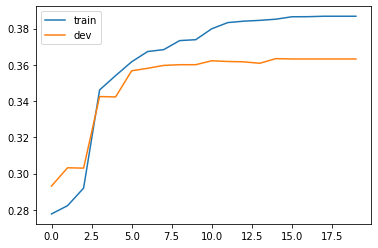

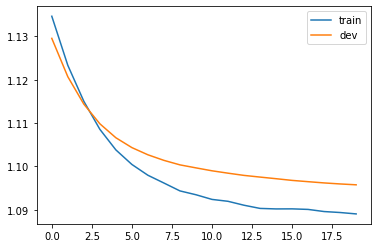

In [133]:
plt.plot(train_accs, label='train')
plt.plot(dev_accs, label='dev')
plt.legend()
plt.show()
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

In [134]:
# test
sentiment_classifier.eval()
test_correct = 0
with torch.no_grad():
    for i, (prediction, sentiment) in enumerate(test_loader):
        prediction = prediction.to(device)
        sentiment = sentiment.to(device)
        output = sentiment_classifier(prediction.float())
        test_correct += (torch.argmax(output, dim=1) == sentiment).sum().item()
test_acc = test_correct / len(test_loader.dataset)
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.4267


## Subpart 2

### Step 1: Use [this paper](https://arxiv.org/abs/2112.13547) to create new images with data augmentation

In [ ]:
# create new images with data augmentation with the method mentioned in https://arxiv.org/abs/2112.13547
# the new images should be saved in the data/train_augmented folder
# the new images should be saved with the same name as the original image with the suffix _augmented_1, _augmented_2, etc.

# define the data augmentation pipeline
class PRIME:
    def __init__(self):
        # TODO: implement this function
        pass
    
    def operation1(self, image:Image) -> Image:
        raise NotImplementedError
    
    def operation2(self, image:Image) -> Image:
        raise NotImplementedError
    
    def augment(self, image:Image) -> Image:
        # TODO: implement this function
        raise NotImplementedError

# create the PRIME object
prime = PRIME()

In [ ]:
# define a function that takes as input the image path, and the PRIME object and the augmented images path and number of augmented images to create
# the function should read the image, apply the PRIME augmentation pipeline to the image, and save the augmented images in the augmented images path
def augment_image(image_path, data_augmenter, augmented_images_path, num_augmented_images=10):
    # TODO: implement this function

### Step 2

In [ ]:
# Evaluate FaceSentimentClassifier model with the augmented data
# create the augmented dataset class
class AugmentedCroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        # TODO: implement this function
        raise NotImplementedError

    def __getitem__(self, index):
        # TODO: implement this function
        raise NotImplementedError
        
    def __len__(self):
        # TODO: implement this function
        raise NotImplementedError

In [ ]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
image_transform = None # TODO

train_dataset = None # TODO
dev_dataset = None # TODO
test_dataset = None # TODO

train_loader = None # TODO
dev_loader = None # TODO
test_loader = None # TODO

In [ ]:
# use model trained on the original data to evaluate on the augmented data
# define a funcion that takes as input the model, the data loader, and the device and gives the accuracy of the model on the data loader
def get_accuracy(model, data_loader, device):
    # TODO: implement this function
    raise NotImplementedError

### Step 3

In [ ]:
# Create a new dataset that combines the original data and the augmented data
# define the combined dataset class
class CombinedCroppedFaces(Dataset):
    def __init__(self, faces_path, sentiments_path, transform=None):
        # TODO: implement this function
        raise NotImplementedError

    def __getitem__(self, index):
        # TODO: implement this function
        raise NotImplementedError

    def __len__(self):
        # TODO: implement this function
        raise NotImplementedError
        

In [ ]:
# create instances of the custom dataset class for the train, dev, and test sets
# define the data loaders for the train, dev, and test sets
# define the image transform for the train, dev, and test sets
image_transform = None # TODO

train_dataset = None # TODO
dev_dataset = None # TODO
test_dataset = None # TODO

train_loader = None # TODO
dev_loader = None # TODO
test_loader = None # TODO

In [ ]:
# train the model on the combined dataset
# define the model, move it to device, and define the optimizer and loss function
model = None # TODO
model = model.to(device)

optimizer = None # TODO
loss_function = None # TODO

# train the model
train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10)

# Part 2

### Step 1

In [ ]:
# Use on of the architectures from https://pytorch.org/vision/stable/models.html or any other architecture to train the model on the combined dataset
# define the model, move it to device, and define the optimizer and loss function
# change the model architecture to be able to classify 3 classes
model = None # TODO
model = model.to(device)

optimizer = None # TODO
loss_function = None # TODO

### Step 2

In [ ]:
# Define data loaders for the train, dev, and test sets from MSCTD
train_loader = None # TODO
dev_loader = None # TODO
test_loader = None # TODO

### Step 3

In [ ]:
# train the model
train_losses, train_accs, dev_losses, dev_accs = train(model, train_loader, dev_loader, optimizer, loss_function, num_epochs=10)

In [ ]:
# plot the train and dev losses and accuracies
plot_train_dev(train_losses, train_accs, dev_losses, dev_accs)

# Part 3